![](brain.png)

In [2]:
import numpy as np
import matplotlib.pyplot as plot

# Régression logistique

## Mise en situation
Je travaille pour un organisme de crédit, je dois deviner rapidement la probabilité qu'une personne soit un "bon payeur" ou un "mauvais payeur" en fonction de son profil.

Je ne vois pas trop comment la régression linéaire pourrait m'aider...

## Régression logistique
### C'est quoi ?
Jusque-là, nous avons travaillé sur un modèle qui nous donne une valeur quantitative (un nombre) en sortie. La classification est un autre type de problème, qui nécessite un autre type de modèle - ou en tout cas une adaptation de ce qu'on a déjà fait.

On dispose aujourd'hui 
* d'un modèle linéaire : $f_\theta(x) = x^T.\theta$, qui nous renvoie un réel
* d'une fonction de coût $J(\theta) = \frac{1}{m}\sum_{i=1}^m{(f_\theta(x_i)-y_i)^2}$
* du gradient $\frac{dJ}{d\theta}$ de cette fonction, qui nous permet soit de trouver une solution directe, soit d'appliquer une descente de gradient

On souhaite désormais disposer, pour une catégorie d'objets à identifier :
* d'un modèle qui nous renvoie 1 (objet dans la catégorie) ou 0 (hors catégorie) - ou à la rigueur une valeur entre 0 et 1, une probabilité d'appartenance à la catégorie
* d'une fonction de coût qui marche bien pour ce modèle
* du gradient associé

### La fonction sigmoïde
La fonction sigmoïde est définie par $f(x) = \frac{1}{1+e^{-x}}$. Graphiquement ça ressemble à ça :

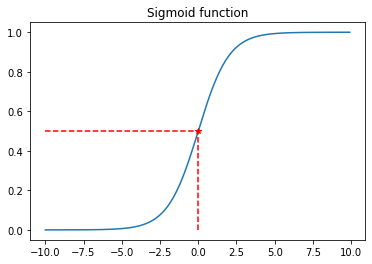

In [3]:
def sigmoid(x): return 1/(1+np.exp(-x))

p_x = np.arange(-10, 10, .1)
p_y = sigmoid(p_x)
plot.plot(p_x, p_y)
plot.plot(0,sigmoid(0),"r*")
plot.plot([0,0],[0,sigmoid(0)], "r--")
plot.plot([-10,0],[sigmoid(0), sigmoid(0)], "r--")
t = plot.title('Sigmoid function')

On remarque que 
* pour $x=0$, $sigmoid(x)=0.5$
* pour $x>0$, $sigmoid(x)>0.5$
* pour $x<0$, $sigmoid(x)<0.5$

On pourrait utiliser cette fonction dans notre modèle, combiné avec un modèle linéaire : on commence par calculer une valeur numérique réelle, et on y applique la sigmoïde pour obtenir une probabilité.

Plus la valeur calculée dans la première étape est supérieure à 0 et plus la probabilité est grande; plus elle est inférieure à 0 et plus la probabilité est faible.

### Le modèle
On va donc définir un nouveau modèle _logistique_ d'après la nouvelle fonction $f$:

$f_\theta(x) = sigmoid(\sum_{i=0}^n{(\theta_i.x_i)}) = sigmoid(x^T.\theta)$

On va aussi définir une fonction de coût $J(\theta)$ : pour celà il faut d'abord savoir ce qu'on appelle une erreur.

Quand $y$, la valeur attendue, vaut 1, on s'attend à avoir f(x) le plus près de 1 possible; et inversement quand $y$ vaut 0 on cherche f(x) le plus proche de 0 possible. La fonction généralement retenue est :

$J(\theta) = \frac{1}{m}\sum_{i=1}^m{\left[
-y^{(i)}.log\left(f_\theta(x^{(i)})\right)
-(1-y^{(i)}).log\left(1-f_\theta(x^{(i)})\right)
\right]}$

Quand $y$ vaut 1, on ne considère que le premier terme (l'autre est nul), et il vaut $-log\left(f_\theta(x^{(i)})\right)$ : plus $f_\theta(x^{(i)})$ est proche de 1 et plus l'erreur est faible, et inversement.

Et quand $y$ vaut 0, c'est le second terme qu'on considère, et pareil plus $f_\theta(x^{(i)})$ est proche de 0, plus l'erreur est faible et inversement.

On a l'habitude aussi de sortir le signe négatif : 

$J(\theta) = -\frac{1}{m}\sum_{i=1}^m{\left[
y^{(i)}.log\left(f_\theta(x^{(i)})\right)
+(1-y^{(i)}).log\left(1-f_\theta(x^{(i)})\right)
\right]}$

### Le gradient
Dans un premier temps, calculons la dérivée de la sigmoïde $s(x)$. Vous pourrez vérifier le résultat suivant : $s'(x) = (1-s(x)).s(x)$

La dérivée partielle $\frac{\partial f_\theta}{\partial \theta_i}$ peut aussi se calculer facilement maintenant : $\frac{\partial f_\theta}{\partial \theta_i} = (1-f_\theta(x)).f_\theta(x).x_i$, il s'agit de la dérivée d'une composition de fonction (FoG)' = F'oG.G'

On poursuit avec les logarithmes de $f$ ou de $1-f$, et on termine avec $J$ : $\frac{\partial J}{\partial \theta_i} = \frac{1}{m}\sum_{z=1}^m{\left[(f_\theta(x^{(z)})-y^{(z)}).x_i^{(z)}\right]}$

La formule finale matricielle est : $\frac{dJ}{d\theta} = \frac{1}{m}(X^T.(f_\theta(X)-Y)$

_Remarque intéressante:_ la dérivée du gradient est assez similaire à ce qu'on a vu pour la régression linéaire. 
Dans la régression linéaire, on avait $\frac{dJ}{d\theta} = \frac{1}{m}X^T.(X.\theta-Y)$, or $X.\theta = f_\theta(X)$ dans le cadre de la régression linéaire.




## Simulation rapide
Validons rapidement le concept d'une descente de gradient sur une régression logistique

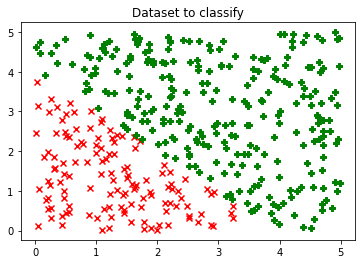

In [4]:
np.random.seed(2)

# Pour les individus (a,b), on essaye de détecter ceux tels que a+b >= 4
X = np.random.rand(400, 2) * 5
Y = (np.sum(X, axis = 1, keepdims=True) >= 4)

# Visualisation des données
fig = plot.figure()
plot.scatter(X[np.where(1-Y)[0],0], X[np.where(1-Y)[0],1], c="r", marker="x")
plot.scatter(X[np.where(Y)[0],0], X[np.where(Y)[0],1], c="g", marker="P")
t = plot.title('Dataset to classify')

In [5]:
def f(x, theta):
    return sigmoid(np.dot(x, theta))

def solve_model(x, y, alpha=0.1, iterations=1000):
    m = x.shape[0]
    #On ajoute toujours la colonne de 1
    Xtmp = np.concatenate([np.ones((m,1)), x], axis = 1)
    
    theta = np.ones((Xtmp.shape[1], 1))
    for i in range(iterations):
        evaluations = f(Xtmp, theta)
        errors = evaluations - y
        gradient = np.dot(Xtmp.T, errors) / m
        theta = theta - alpha*gradient
    return theta

theta = solve_model(X, Y)

test_points=np.array([[1, 0,0], [1, 3,3], [1, 2,3], [1, 2,2], [1, 1.7,1.8], [1, 2.05, 1.95], [1, 1.96, 2.03]])
for i in test_points:
    print("Point (%f,%f) in class with probability %f" %(i[1], i[2], f(i, theta)) + ' - and truth is : ' + ('yes' if i[1]+i[2] >= 4 else 'no'))

Point (0.000000,0.000000) in class with probability 0.008973 - and truth is : no
Point (3.000000,3.000000) in class with probability 0.961309 - and truth is : yes
Point (2.000000,3.000000) in class with probability 0.862166 - and truth is : yes
Point (2.000000,2.000000) in class with probability 0.639598 - and truth is : yes
Point (1.700000,1.800000) in class with probability 0.476986 - and truth is : no
Point (2.050000,1.950000) in class with probability 0.640975 - and truth is : yes
Point (1.960000,2.030000) in class with probability 0.635583 - and truth is : no


C'est pas mal ! Bon bien entendu c'est pas non plus parfait : le dernier exemple est très borderline et il est mal reconnu (la somme vaut 3.99...) mais la probabilité n'est pas non plus exceptionnelle !

Avec un peu de code en plus, on peut même voir les limites les limites du modèle

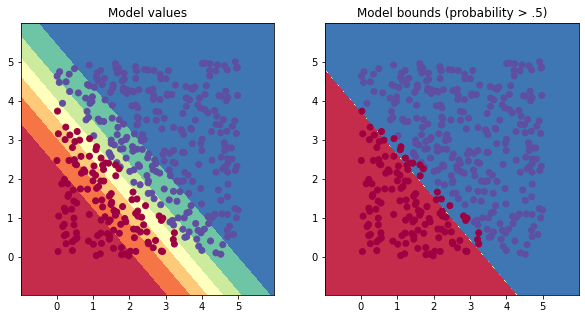

In [6]:
def plot_bounds(model, X, Y, draw_box):
    h=0.01
    mesh_x, mesh_y = np.meshgrid(
        np.arange(X[:,0].min() - 1, X[:,0].max() + 1, h),
        np.arange(X[:,1].min() - 1, X[:,1].max() + 1, h))
    Z = model(np.c_[np.ones((mesh_x.ravel().shape[0], 1)), mesh_x.ravel(), mesh_y.ravel()])
    Z = Z.reshape(mesh_x.shape)
    draw_box.contourf(mesh_x,mesh_y,Z, cmap=plot.cm.Spectral)
    draw_box.scatter(X[:,0], X[:,1], c=Y, cmap=plot.cm.Spectral)

fig = plot.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
plot.title('Model values')
plot_bounds(lambda x: f(x, theta), X, Y, ax)

ax = fig.add_subplot(122)
plot.title('Model bounds (probability > .5)')
plot_bounds(lambda x: f(x, theta)>.5, X, Y, ax)



On voit bien sur la seconde figure que les points borderlines sont dans la mauvaise zone, mais sur la première figure on peut constater que c'est quand même une zone un peu floue

### Au sujet de l'implémentation
Tout ce qu'on a pu voir la semaine dernière (normalisation, mini-batch, ...) reste applicable (et devrait être appliqué !)

Et appliquer un modèle logistique sur une fonction polynomiale permet de modéliser des fonctions plus complexes aussi.

## Retour à la mise en situation

### Chargement des données

Les données se présentent sous la forme suivante : 
* revenus du client
* nombre de personnes à charge
* charges fixes
* existence dans le passé d'un défaut de paiement sur un autre crédit
* défaut de paiement sur ce crédit

In [6]:
data = np.load('data/d06_data.npy')
Xtrain = data[:, 0:-1]
Ytrain = data[:, -1].reshape(-1, 1)

samples = Xtrain.shape[0]
print("%i samples loaded" % (samples))

10000 samples loaded


On n'a plus qu'à entrainer le modèle !

In [7]:
def sigmoid(x): return 1/(1+np.exp(-x))
def f(x, theta): return sigmoid(np.dot(x, theta))
def predict(x, theta, mus, sigmas):
    x_mod = (x - mus)/sigmas
    x_mod = np.concatenate([np.ones((x.shape[0], 1)), x_mod], axis = 1)
    return f(x_mod, theta)

def cost(x, y, theta):
    y_p = f(x, theta)
    return -np.average(y * np.log(y_p) + (1-y) * np.log(1-y_p))

def train_model(X, Y, alpha = 0.01, iterations = 1000):
    m = X.shape[0]
    
    #normalization
    mus = np.mean(X, axis = 0)
    sigmas = np.std(X, axis = 0)
    
    Xtmp = np.concatenate([np.ones((m, 1)), (X-mus)/sigmas], axis = 1)
    
    theta = np.random.rand(Xtmp.shape[1], 1) * 0.01
    costs = []
    for i in range(iterations):
        if i%100 == 0: costs.append(cost(Xtmp,Y,theta))
        evaluations = f(Xtmp, theta)
        errors = evaluations - Y
        grad = np.dot(Xtmp.T, errors) / m
        theta = theta - alpha * grad
    return theta,costs, mus, sigmas

In [8]:
theta, costs, mus, sigmas = train_model(Xtrain, Ytrain, alpha=0.02, iterations = 10000)

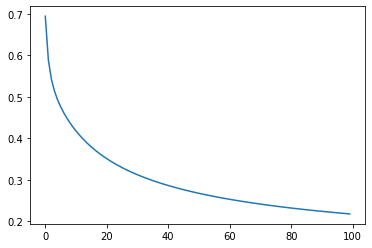

In [9]:
plot.plot(range(len(costs)), costs)
plot.title = 'Cost by hundreds of iterations'

C'est pas trop mal apparemment !

On va tester avec quelques personnes pour voir un peu le résultat :

In [10]:
test = np.array([[2000, 3, 1800, 1], [7000, 6, 1300, 0], [1000, 5, 900, 0], [6000, 5, 1200, 0]])
probabilities = np.floor(predict(test, theta, mus, sigmas)*100)
results = np.floor(predict(test, theta, mus, sigmas) + .5)

for i in range(test.shape[0]):
    print('Client revenue: %i, %i dependents, %i fixed charges, %s : %s (%i %%)' %(
        test[i,0],
        test[i,1],
        test[i,2],
        'at least one payment default in the past' if test[i,3] else 'never missed a payment',
        'danger' if results[i] else 'safe',
        probabilities[i])
         )

Client revenue: 2000, 3 dependents, 1800 fixed charges, at least one payment default in the past : danger (99 %)
Client revenue: 7000, 6 dependents, 1300 fixed charges, never missed a payment : safe (0 %)
Client revenue: 1000, 5 dependents, 900 fixed charges, never missed a payment : danger (98 %)
Client revenue: 6000, 5 dependents, 1200 fixed charges, never missed a payment : safe (0 %)


On va regarder par exemple l'évolution du résultat pour un seul paramètre qui change :

In [11]:
test = np.array([[2000, 3, 1800, 0], [3000, 3, 1800, 0], [4000, 3, 1800, 0], [5000, 3, 1800, 0]])
probabilities = np.floor(predict(test, theta, mus, sigmas)*100)
results = np.floor(predict(test, theta, mus, sigmas) + .5)

for i in range(test.shape[0]):
    print('Client revenue: %i, %i dependents, %i fixed charges, %s : %s (%i %%)' %(
        test[i,0],
        test[i,1],
        test[i,2],
        'at least one payment default in the past' if test[i,3] else 'never missed a payment',
        'danger' if results[i] else 'safe',
        probabilities[i])
         )
print('----------------------')
test = np.array([[4000, 4, 1000, 0], [4000, 4, 1500, 0], [4000, 4, 2000, 0], [4000, 4, 2500, 0]])
probabilities = np.floor(predict(test, theta, mus, sigmas)*100)
results = np.floor(predict(test, theta, mus, sigmas) + .5)

for i in range(test.shape[0]):
    print('Client revenue: %i, %i dependents, %i fixed charges, %s : %s (%i %%)' %(
        test[i,0],
        test[i,1],
        test[i,2],
        'at least one payment default in the past' if test[i,3] else 'never missed a payment',
        'danger' if results[i] else 'safe',
        probabilities[i])
         )
print('----------------------')
test = np.array([[4000, 2, 800, 0], [4000, 4, 800, 0], [4000, 6, 800, 0], [4000, 8, 800, 0]])
probabilities = np.floor(predict(test, theta, mus, sigmas)*100)
results = np.floor(predict(test, theta, mus, sigmas) + .5)

for i in range(test.shape[0]):
    print('Client revenue: %i, %i dependents, %i fixed charges, %s : %s (%i %%)' %(
        test[i,0],
        test[i,1],
        test[i,2],
        'at least one payment default in the past' if test[i,3] else 'never missed a payment',
        'danger' if results[i] else 'safe',
        probabilities[i])
         )
print('----------------------')
test = np.array([[4000, 4, 1200, 0], [4000, 4, 1200, 1]])
probabilities = np.floor(predict(test, theta, mus, sigmas)*100)
results = np.floor(predict(test, theta, mus, sigmas) + .5)

for i in range(test.shape[0]):
    print('Client revenue: %i, %i dependents, %i fixed charges, %s : %s (%i %%)' %(
        test[i,0],
        test[i,1],
        test[i,2],
        'at least one payment default in the past' if test[i,3] else 'never missed a payment',
        'danger' if results[i] else 'safe',
        probabilities[i])
         )

Client revenue: 2000, 3 dependents, 1800 fixed charges, never missed a payment : danger (99 %)
Client revenue: 3000, 3 dependents, 1800 fixed charges, never missed a payment : danger (91 %)
Client revenue: 4000, 3 dependents, 1800 fixed charges, never missed a payment : danger (55 %)
Client revenue: 5000, 3 dependents, 1800 fixed charges, never missed a payment : safe (12 %)
----------------------
Client revenue: 4000, 4 dependents, 1000 fixed charges, never missed a payment : safe (6 %)
Client revenue: 4000, 4 dependents, 1500 fixed charges, never missed a payment : safe (38 %)
Client revenue: 4000, 4 dependents, 2000 fixed charges, never missed a payment : danger (83 %)
Client revenue: 4000, 4 dependents, 2500 fixed charges, never missed a payment : danger (97 %)
----------------------
Client revenue: 4000, 2 dependents, 800 fixed charges, never missed a payment : safe (1 %)
Client revenue: 4000, 4 dependents, 800 fixed charges, never missed a payment : safe (3 %)
Client revenue: 400

On constate que les revenus font décroitre le risque, les charges fixes / le nombre de personnes à charge l'augmentent. Et le défaut de paiement dans le passé est un facteur très important aussi !